# 2-Qubit Clifford Group Decomposition

Generate the decomposition of the 2-qubit Clifford group according to: https://arxiv.org/abs/1402.4848

```
# Copyright 2024 IQM Benchmarks developers
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

In [1]:
import pickle
from qiskit.quantum_info import Clifford
import qiskit.quantum_info as qi
from qiskit.circuit.library import CZGate
from qiskit import QuantumCircuit
import numpy as np

## Generate the 1Q Clifford group

In [2]:
c0 = QuantumCircuit(1)
c = [c0.copy() for _ in range(24)]

half = np.pi / 2

X2 = c0.copy()
X2.r(half, 0, 0)  # meaning X/2
X2.to_gate()
Y2 = c0.copy()
Y2.r(half, half, 0)  # meaning Y/2
Y2.to_gate()
X2m = c0.copy()
X2m.r(-half, 0, 0)  # meaning -X/2
X2m.to_gate()
Y2m = c0.copy()
Y2m.r(-half, half, 0)  # meaning -Y/2
Y2m.to_gate()

# Paulis
c[0].name = "I"
c[0].r(0, 0, 0)
c[1].name = "X"
c[1].r(np.pi, 0, 0)
c[2].name = "Y"
c[2].r(np.pi, half, 0)
c[3].name = "Y, X"
c[3].compose(c[1], inplace=True)
c[3].compose(c[2], inplace=True)

# 2Pi/3 rotations
c[4].name = "X/2, Y/2"
c[4].compose(Y2, inplace=True)
c[4].compose(X2, inplace=True)
c[5].name = "X/2, -Y/2"
c[5].compose(Y2m, inplace=True)
c[5].compose(X2, inplace=True)
c[6].name = "-X/2, Y/2"
c[6].compose(Y2, inplace=True)
c[6].compose(X2m, inplace=True)
c[7].name = "-X/2, -Y/2"
c[7].compose(Y2m, inplace=True)
c[7].compose(X2m, inplace=True)
c[8].name = "Y/2, X/2"
c[8].compose(X2, inplace=True)
c[8].compose(Y2, inplace=True)
c[9].name = "Y/2, -X/2"
c[9].compose(X2m, inplace=True)
c[9].compose(Y2, inplace=True)
c[10].name = "-Y/2, X/2"
c[10].compose(X2, inplace=True)
c[10].compose(Y2m, inplace=True)
c[11].name = "-Y/2, -X/2"
c[11].compose(X2m, inplace=True)
c[11].compose(Y2m, inplace=True)

# Pi/2 rotations
c[12].name = "X/2"
c[12].compose(X2, inplace=True)
c[13].name = "-X/2"
c[13].compose(X2m, inplace=True)
c[14].name = "Y/2"
c[14].compose(Y2, inplace=True)
c[15].name = "-Y/2"
c[15].compose(Y2m, inplace=True)
c[16].name = "-X/2, Y/2, X/2"
c[16].compose(X2, inplace=True)
c[16].compose(Y2, inplace=True)
c[16].compose(X2m, inplace=True)
c[17].name = "-X/2, -Y/2, X/2"
c[17].compose(X2, inplace=True)
c[17].compose(Y2m, inplace=True)
c[17].compose(X2m, inplace=True)

# Hadamard-like
c[18].name = "X, Y/2"
c[18].compose(Y2, inplace=True)
c[18].compose(c[1], inplace=True)
c[19].name = "X, -Y/2"
c[19].compose(Y2m, inplace=True)
c[19].compose(c[1], inplace=True)
c[20].name = "Y, X/2"
c[20].compose(X2, inplace=True)
c[20].compose(c[2], inplace=True)
c[21].name = "Y, -X/2"
c[21].compose(X2m, inplace=True)
c[21].compose(c[2], inplace=True)
c[22].name = "X/2, Y/2, X/2"
c[22].compose(X2, inplace=True)
c[22].compose(Y2, inplace=True)
c[22].compose(X2, inplace=True)
c[23].name = "-X/2, Y/2, -X/2"
c[23].compose(X2m, inplace=True)
c[23].compose(Y2, inplace=True)
c[23].compose(X2m, inplace=True)


clifford_sqg = {}
for i in range(24):
    clifford_sqg[c[i].name] = c[i]

S1 = [clifford_sqg[k] for k in ["I", "Y/2, X/2", "-X/2, -Y/2"]]
S1X2 = [clifford_sqg[k] for k in ["X/2", "X/2, Y/2, X/2", "-Y/2"]]
S1Y2 = [clifford_sqg[k] for k in ["Y/2", "Y, X/2", "-X/2, -Y/2, X/2"]]

Verify the condition $\displaystyle{\sum_{k,\,k^\prime=1}^K}\left|\mathrm{tr}\left(U_{k^\prime}^{\dagger}U_k\right)\right|^4/K^2 = 2$   (Eq. S2)

In [3]:
# Check that the generated set for 2Q Cliffords satisfies 2-design condition
count = []
K = 24
c_keys = list(clifford_sqg.keys())
aux = 0
total_triangle = K * (K - 1) / 2
for i in range(K):
    c1 = qi.Operator(clifford_sqg[c_keys[i]]).adjoint()
    for j in range(i + 1, K):
        c2 = qi.Operator(clifford_sqg[c_keys[j]])
        c3 = c1 @ c2
        tr = np.abs(c3.to_matrix().trace())
        count.append(2 * tr**4)
        aux += 1
        print('\r', f"... {total_triangle-aux:.0f} terms left     ", end='')

# Add the diagonals
count.append((2**4) * K)

print(f"\nSum: {sum(count)/K**2}")

 ... 0 terms left       
Sum: 2.0


## Generate the 2Q Clifford group

In [4]:
clifford_2qg = {}

In [5]:
# Class 1: products of Cliffords
c2q_0 = QuantumCircuit(2)
c2q = [c2q_0.copy() for _ in range(24**2)]
counter = 0
for c1 in clifford_sqg.values():
    for c2 in clifford_sqg.values():
        c2q[counter].compose(c1, [0], inplace=True)
        c2q[counter].compose(c2, [1], inplace=True)
        label = str(Clifford(c2q[counter]).to_labels(mode="B"))
        c2q[counter].name = f"sqg_class_{label}"
        clifford_2qg[label] = c2q[counter]
        counter += 1

print(counter == 24**2)
print(len(clifford_2qg.values()) == 24**2)

True
True


In [6]:
# Class 2: CNOT-like
c2q_0 = QuantumCircuit(2)
c2q = [c2q_0.copy() for _ in range((24**2) * (3**2))]
counter = 0
for c1 in clifford_sqg.values():
    for c2 in clifford_sqg.values():
        for s1 in S1:
            for sy2 in S1Y2:
                c2q[counter].compose(c1, [0], inplace=True)
                c2q[counter].compose(c2, [1], inplace=True)
                c2q[counter].compose(CZGate(), [0, 1], inplace=True)
                c2q[counter].compose(s1, [0], inplace=True)
                c2q[counter].compose(sy2, [1], inplace=True)
                label = str(Clifford(c2q[counter]).to_labels(mode="B"))
                c2q[counter].name = f"cnot_class_{label}"
                clifford_2qg[label] = c2q[counter]
                counter += 1

print(counter == (24**2) * (3**2))
print(len(clifford_2qg.values()) == (24**2) * (3**2) + 24**2)

True
True


In [7]:
# Class 3: iSWAP-like
c2q_0 = QuantumCircuit(2)
c2q = [c2q_0.copy() for _ in range((24**2) * (3**2))]
counter = 0
for c1 in clifford_sqg.values():
    for c2 in clifford_sqg.values():
        for sy1 in S1Y2:
            for sx2 in S1X2:
                c2q[counter].compose(c1, [0], inplace=True)
                c2q[counter].compose(c2, [1], inplace=True)
                c2q[counter].compose(CZGate(), [0, 1], inplace=True)
                c2q[counter].compose(Y2, [0], inplace=True)
                c2q[counter].compose(X2m, [1], inplace=True)
                c2q[counter].compose(CZGate(), [0, 1], inplace=True)
                c2q[counter].compose(sy1, [0], inplace=True)
                c2q[counter].compose(sx2, [1], inplace=True)
                label = str(Clifford(c2q[counter]).to_labels(mode="B"))
                c2q[counter].name = f"i_swap_class_{label}"
                clifford_2qg[label] = c2q[counter]
                counter += 1

print(counter == (24**2) * (3**2))
print(len(clifford_2qg.values()) == 2 * (24**2) * (3**2) + 24**2)

True
True


In [8]:
# Class 4: SWAP-like
c2q_0 = QuantumCircuit(2)
c2q = [c2q_0.copy() for _ in range((24**2) * (3**2))]
counter = 0
for c1 in clifford_sqg.values():
    for c2 in clifford_sqg.values():
        c2q[counter].compose(c1, [0], inplace=True)
        c2q[counter].compose(c2, [1], inplace=True)
        c2q[counter].compose(CZGate(), [0, 1], inplace=True)
        c2q[counter].compose(Y2m, [0], inplace=True)
        c2q[counter].compose(Y2, [1], inplace=True)
        c2q[counter].compose(CZGate(), [0, 1], inplace=True)
        c2q[counter].compose(Y2, [0], inplace=True)
        c2q[counter].compose(Y2m, [1], inplace=True)
        c2q[counter].compose(CZGate(), [0, 1], inplace=True)
        c2q[counter].compose(Y2, [1], inplace=True)
        label = str(Clifford(c2q[counter]).to_labels(mode="B"))
        c2q[counter].name = f"swap_class_{label}"
        clifford_2qg[label] = c2q[counter]
        counter += 1

print(counter == 24**2)
print(len(clifford_2qg.values()) == 2 * ((24**2) * (3**2) + 24**2))

True
True


## Dump on a pickle file

In [9]:
clifford_1qg = {str(Clifford(c[i]).to_labels(mode="B")): c[i] for i in range(24)}
with open('clifford_1q.pkl', 'wb') as f:
    pickle.dump(clifford_1qg, f)

In [10]:
with open('clifford_2q.pkl', 'wb') as f:
    pickle.dump(clifford_2qg, f)

## Load

In [11]:
with open('clifford_2q.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

## Count elements

In [12]:
def count_rcz(c_list):
    no_cz = []
    no_r = []
    for c in c_list:
        if 'cz' in c.count_ops().keys():
            no_cz.append(c.count_ops()['cz'])
        else:
            no_cz.append(0)
        if 'r' in c.count_ops().keys():
            no_r.append(c.count_ops()['r'])
        else:
            print(c.count_ops().keys())
            no_r.append(0)
    return no_cz, no_r

## 2Q

In [13]:
num_2qcz, num_2qr = count_rcz(list(loaded_dict.values()))
print(f"cz: {np.mean(num_2qcz)}, r: {np.mean(num_2qr)}")

cz: 1.5, r: 8.2


## 1Q

In [14]:
num_1qcz, num_1qr = count_rcz(list(clifford_sqg.values()))
print(f"cz: {np.mean(num_1qcz)}, r: {np.mean(num_1qr)}")

cz: 0.0, r: 1.875


## A way to work out the inverse of sequences


Inverse:


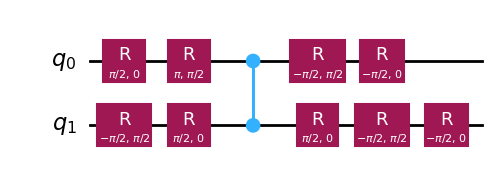


Composition of the two is identity modulo phase: True


<IPython.core.display.Latex object>

In [15]:
length = 200
g = []
qc = QuantumCircuit(2)
for i in range(length):
    g.append(list(loaded_dict.values())[np.random.randint(11520)])
    if length <= 10:
        print(f"g{[i]}: {g[i].name}")
    qc.compose(g[i], inplace=True)
    qc.barrier()

if length <= 10:
    display(qc.draw(output='mpl', style='iqp', fold=0))

print("\nInverse:")
qc_aux = QuantumCircuit(2)
qc_aux.compose(qc, inplace=True)
label = str(Clifford(qc_aux).adjoint().to_labels(mode="B"))
qcinv = loaded_dict[label]
display(qcinv.draw(output='mpl', style='iqp'))

op_seq = qi.Operator(qc) @ qi.Operator(qcinv)
print(f"\nComposition of the two is identity modulo phase: {op_seq.equiv(qi.Pauli('II'))}")
display(op_seq.draw(output="latex"))

## 2-design condition
Verify the condition $\displaystyle{\sum_{k,\,k^\prime=1}^K}\left|\mathrm{tr}\left(U_{k^\prime}^{\dagger}U_k\right)\right|^4/K^2 = 2$   (Eq. S2)

**WARNING**: in total there are $n=11,520^2 = 132,710,400$ values in the sum !

It suffices to compute the values in a triangular part of the matrix $U_{k^\prime}^{\dagger}U_k$  --- however there are still $n(n-1)/2$ such terms ! 

In [16]:
# Check that the generated set for 2Q Cliffords satisfies 2-design condition
count = []
K = 11520
c_keys = list(loaded_dict.keys())
total_triangle = K * (K - 1) / 2

ops = []
print("Converting Cliffords to Operators ...")
for i in range(K):
    ops.append(qi.Operator(loaded_dict[c_keys[i]]))

print("Computing the sum ...")
aux = 0
for i in range(K):
    adj = ops[i].adjoint()
    for j in range(i + 1, K):
        prod = adj @ ops[j]
        tr = np.abs(prod.to_matrix().trace())
        count.append(2 * tr**4)

        aux += 1
        if aux % 100000 == 0 or aux == total_triangle:
            print('\r', f"... {total_triangle-aux:.0f} terms left     ", end='')

# Add the diagonals
count.append((4**4) * K)

print(f"\nDone.\n\nSum: {sum(count)/K**2}")

Converting Cliffords to Operators ...
Computing the sum ...
 ... 0 terms left            
Done.

Sum: 2.0
